<a href="https://colab.research.google.com/github/MuhRizkiP/Tugas-Sains-Data/blob/main/regresi_Typeshi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install -q pandas numpy scikit-learn matplotlib seaborn joblib tensorflow openpyxl
print("✅ Library installed successfully.")


✅ Library installed successfully.


In [24]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import joblib, warnings, os
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


In [25]:
# Simulasi dataset 15-menit interval mirip makalah Sustainability 2024
rng = pd.date_range('2018-05-01', periods=2000, freq='15T')
df = pd.DataFrame(index=rng)

# gunakan np.clip, bukan .clip()
df['total_wifi'] = np.clip(
    20 + 40*np.sin(2*np.pi*(df.index.hour)/24) + np.random.normal(0,5,len(df)),
    a_min=0, a_max=None
)
df['total_occ']  = np.clip(0.6*df['total_wifi'] + np.random.normal(0,3,len(df)), 0, None)
df['outdoor_temp']   = 15 + 5*np.sin(2*np.pi*(df.index.dayofyear)/365) + np.random.normal(0,1,len(df))
df['solar_rad']      = np.abs(200*np.sin(2*np.pi*(df.index.hour)/24) + np.random.normal(0,30,len(df)))
df['rtu_supply_temp']= 18 + np.random.normal(0,1,len(df))
df['total_energy']   = (
    0.5*df['total_occ'] + 1.2*(25 - df['outdoor_temp']).clip(lower=0)
    + 0.01*df['solar_rad'] + np.random.normal(0,3,len(df))
)
df.index.name = 'timestamp'

# Simpan ke CSV
csv_path = "simulated_building_data.csv"
df.to_csv(csv_path)
print(f"✅ Simulated dataset saved as {csv_path}, shape = {df.shape}")
df.head()


✅ Simulated dataset saved as simulated_building_data.csv, shape = (2000, 6)


,total_wifi,total_occ,outdoor_temp,solar_rad,rtu_supply_temp,total_energy
timestamp,,,,,,
2018-05-01 00:00:00,21.251683,12.496664,17.039143,26.365866,17.067001,10.121518
2018-05-01 00:15:00,19.805107,10.421957,18.681360,19.383064,17.202621,13.033429
2018-05-01 00:30:00,16.635560,7.764806,19.113502,10.025570,18.387260,7.777615
2018-05-01 00:45:00,15.151229,9.333113,19.794733,15.396768,18.382571,12.433008
2018-05-01 01:00:00,32.768410,12.495838,19.279059,55.146720,17.664876,13.073216


Dataset shape: (2000, 6)

Data types:
 total_wifi         float64
total_occ          float64
outdoor_temp       float64
solar_rad          float64
rtu_supply_temp    float64
total_energy       float64
dtype: object

Missing values per column:
 total_wifi         0
total_occ          0
outdoor_temp       0
solar_rad          0
rtu_supply_temp    0
total_energy       0
dtype: int64


,total_wifi,total_occ,outdoor_temp,solar_rad,rtu_supply_temp,total_energy
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,24.507056,15.132360,18.862404,128.347243,17.992271,16.260843
std,23.392534,13.882264,1.016728,65.647921,1.011439,7.817669
min,0.000000,0.000000,15.397747,0.151624,14.598457,-0.397233
25%,0.000000,1.377401,18.184844,73.597075,17.294038,9.939886
50%,20.291574,12.365401,18.827287,138.948236,18.034968,14.810970
75%,47.763876,28.392545,19.553882,182.433890,18.672133,22.914393
max,71.316307,47.667322,22.533798,280.492031,21.407149,37.824023


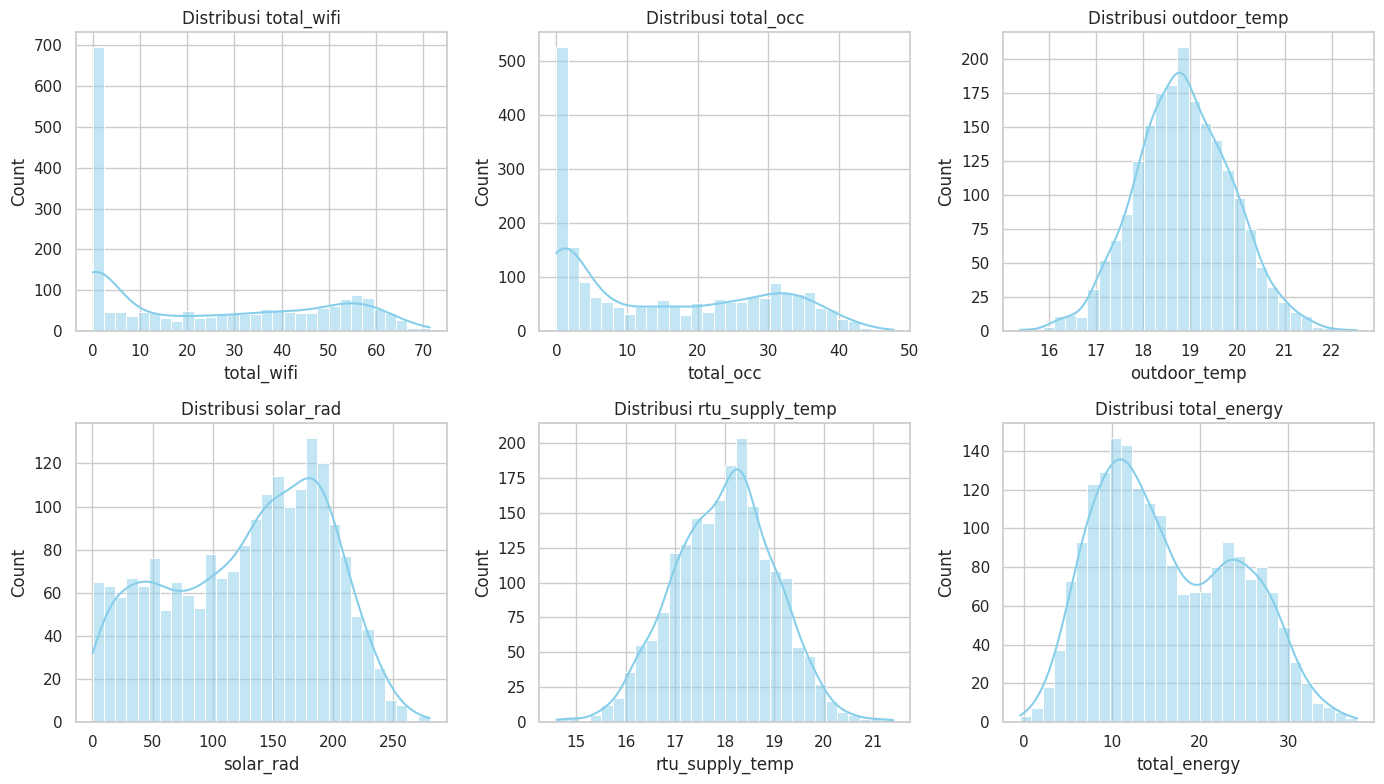

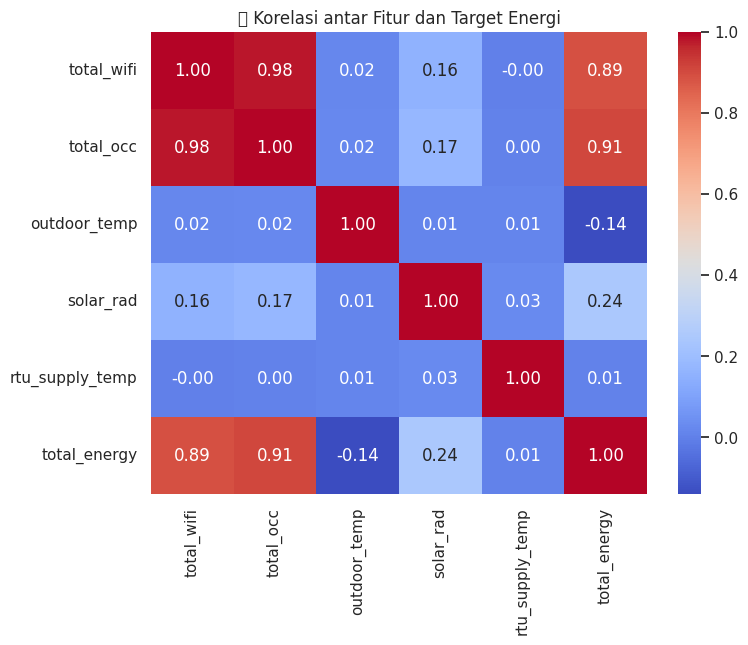

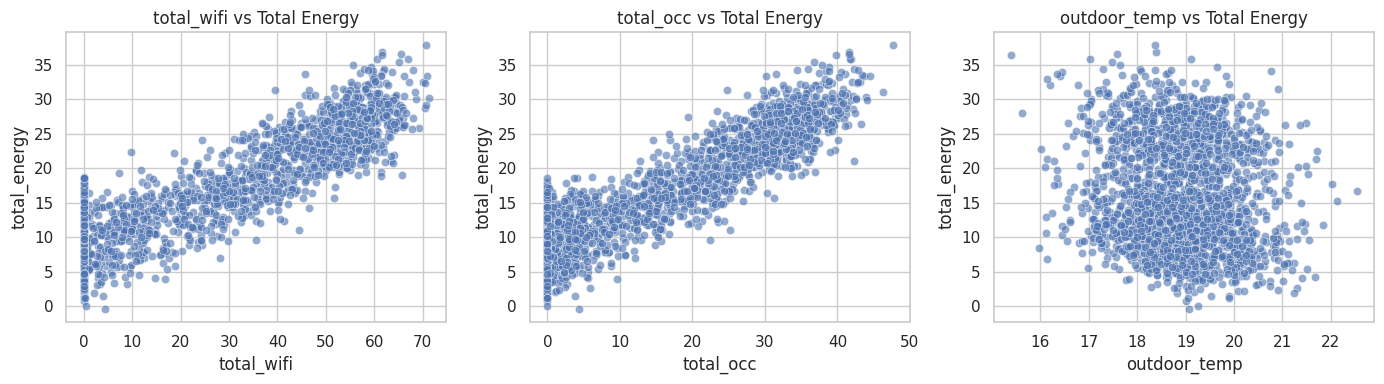

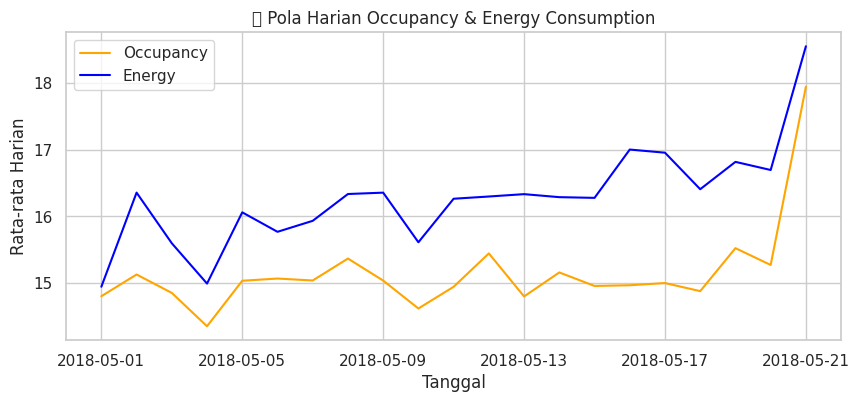

In [26]:
# =========================================
# 📊 CRISP-DM Stage 2: Data Understanding (EDA)
# =========================================

import matplotlib.pyplot as plt
import seaborn as sns

# Tampilkan info dasar dataset
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

# Deskripsi statistik
display(df.describe())

# -----------------------------
# 1️⃣ Distribusi Variabel Numerik
# -----------------------------
numeric_cols = ['total_wifi', 'total_occ', 'outdoor_temp', 'solar_rad', 'rtu_supply_temp', 'total_energy']

plt.figure(figsize=(14,8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2,3,i+1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribusi {col}")
plt.tight_layout()
plt.show()

# -----------------------------
# 2️⃣ Korelasi antar Variabel
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔍 Korelasi antar Fitur dan Target Energi")
plt.show()

# -----------------------------
# 3️⃣ Hubungan antar variabel dengan target
# -----------------------------
plt.figure(figsize=(14,4))
for i, col in enumerate(['total_wifi', 'total_occ', 'outdoor_temp']):
    plt.subplot(1,3,i+1)
    sns.scatterplot(x=df[col], y=df['total_energy'], alpha=0.6)
    plt.title(f"{col} vs Total Energy")
plt.tight_layout()
plt.show()

# -----------------------------
# 4️⃣ Pola harian Occupancy & Energy
# -----------------------------
df_daily = df.resample('D').mean(numeric_only=True)
plt.figure(figsize=(10,4))
plt.plot(df_daily.index, df_daily['total_occ'], label='Occupancy', color='orange')
plt.plot(df_daily.index, df_daily['total_energy'], label='Energy', color='blue')
plt.title("📅 Pola Harian Occupancy & Energy Consumption")
plt.xlabel("Tanggal"); plt.ylabel("Rata-rata Harian")
plt.legend(); plt.grid(True)
plt.show()


In [27]:
# Resample ke 15-menit (sudah)
# Sinkronisasi Wi-Fi (geser 1 jam)
df['wifi_shift'] = df['total_wifi'].shift(4)  # 4 interval × 15 menit = 1 jam
# Kurangi perangkat stasioner (daily min)
daily_min = df['wifi_shift'].resample('D').transform('min')
df['wifi_adj'] = (df['wifi_shift'] - daily_min).clip(lower=0)

# Hapus NA awal akibat shift
df = df.dropna().copy()
print("✅ Preprocessing complete:", df.shape)
df.head()


✅ Preprocessing complete: (1996, 8)


,total_wifi,total_occ,outdoor_temp,solar_rad,rtu_supply_temp,total_energy,wifi_shift,wifi_adj
timestamp,,,,,,,,
2018-05-01 01:00:00,32.768410,12.495838,19.279059,55.146720,17.664876,13.073216,21.251683,21.251683
2018-05-01 01:15:00,27.945934,13.281421,20.035024,109.631645,17.525804,18.111871,19.805107,19.805107
2018-05-01 01:30:00,35.592957,21.359950,19.983294,18.662817,17.976786,12.361138,16.635560,16.635560
2018-05-01 01:45:00,34.458862,24.065450,19.513750,76.453776,17.429113,18.581705,15.151229,15.151229
2018-05-01 02:00:00,42.621395,23.652801,18.946049,48.570612,17.990437,23.685629,32.768410,32.768410


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

X_occ = df[['wifi_adj']].values
y_occ = df['total_occ'].values

# ANN Regressor
def build_ann(input_dim):
    m = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2s, rmses = [], []
for tr, ts in cv.split(X_occ):
    Xt, Xv = X_occ[tr], X_occ[ts]
    yt, yv = y_occ[tr], y_occ[ts]
    m = build_ann(Xt.shape[1])
    m.fit(Xt, yt, epochs=50, batch_size=64, verbose=0,
          callbacks=[EarlyStopping(monitor='loss', patience=5)])
    pred = m.predict(Xv).ravel()
    r2s.append(r2_score(yv, pred))
    rmses.append(mean_squared_error(yv, pred)) # Removed squared=False

print(f"🔹 ANN Occupancy Regressor – Mean R² {np.mean(r2s):.3f}, MSE {np.mean(rmses):.2f}") # Changed RMSE to MSE

# Latih ulang seluruh data untuk prediksi penuh
model_occ = build_ann(1)
model_occ.fit(X_occ, y_occ, epochs=60, batch_size=64, verbose=0)
df['pred_occ'] = model_occ.predict(X_occ).ravel()
joblib.dump(model_occ, "occupancy_model.pkl")
print("✅ Occupancy model trained & saved.")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
🔹 ANN Occupancy Regressor – Mean R² 0.838, MSE 31.19
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Occupancy model trained & saved.


In [29]:
features = ['outdoor_temp','solar_rad','rtu_supply_temp','pred_occ']
target   = 'total_energy'
X = df[features].values
y = df[target].values

# 6 model regresi untuk perbandingan
models = {
    'MLR': LinearRegression(),
    'PR' : Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                     ('lr', LinearRegression())]),
    'DTR': DecisionTreeRegressor(random_state=42),
    'RF' : RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    'SVR': Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf'))])
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv)
    rmse = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv)
    print(f"{name}: R²={scores.mean():.3f}, RMSE={rmse.mean():.2f}")

# Latih model terbaik – Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X, y)
joblib.dump(rf, "energy_rf.pkl")
df['energy_pred'] = rf.predict(X)
print("✅ Energy model trained & saved.")


MLR: R²=0.723, RMSE=4.11
PR: R²=0.742, RMSE=3.96
DTR: R²=0.539, RMSE=5.30
RF: R²=0.736, RMSE=4.01
SVR: R²=0.744, RMSE=3.95
✅ Energy model trained & saved.


In [30]:
r2 = r2_score(df['total_energy'], df['energy_pred'])
mse = mean_squared_error(df['total_energy'], df['energy_pred'])
print(f"🌟 Energy Model Performance – R² = {r2:.3f}, MSE = {mse:.2f}")

# Bandingkan energi aktual vs prediksi menggunakan occupancy aktual
rf_actual = RandomForestRegressor(n_estimators=300, random_state=42)
rf_actual.fit(df[['outdoor_temp','solar_rad','rtu_supply_temp','total_occ']], df['total_energy'])
df['energy_pred_actual'] = rf_actual.predict(df[['outdoor_temp','solar_rad','rtu_supply_temp','total_occ']])

r2_a = r2_score(df['total_energy'], df['energy_pred_actual'])
mse_a = mean_squared_error(df['total_energy'], df['energy_pred_actual'])
print(f"🔁 Error Propagation Check – Actual occ R²={r2_a:.3f}, Pred occ R²={r2:.3f}, Actual occ MSE={mse_a:.2f}, Pred occ MSE={mse:.2f}")

🌟 Energy Model Performance – R² = 0.965, MSE = 2.16
🔁 Error Propagation Check – Actual occ R²=0.978, Pred occ R²=0.965, Actual occ MSE=1.37, Pred occ MSE=2.16


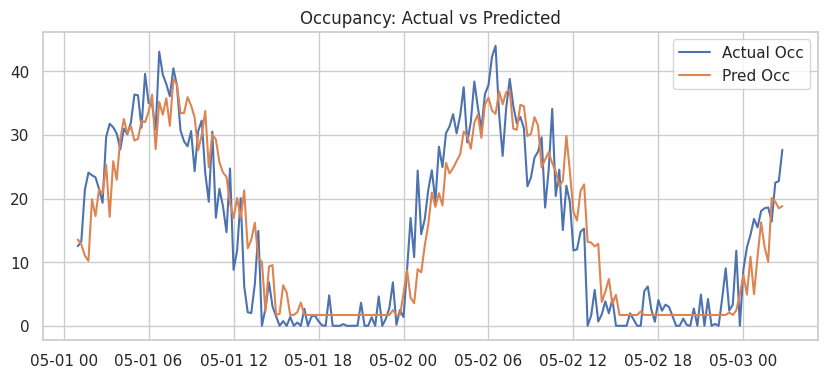

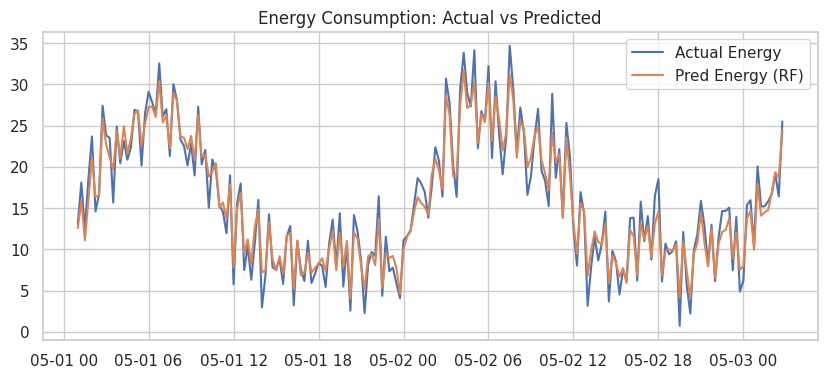

,total_wifi,wifi_adj,total_occ,pred_occ,total_energy,energy_pred
timestamp,,,,,,
2018-05-01 01:00:00,32.768410,21.251683,12.495838,13.555059,13.073216,12.588016
2018-05-01 01:15:00,27.945934,19.805107,13.281421,12.759998,18.111871,15.886215
2018-05-01 01:30:00,35.592957,16.635560,21.359950,11.017968,12.361138,11.094078
2018-05-01 01:45:00,34.458862,15.151229,24.065450,10.202156,18.581705,15.989913
2018-05-01 02:00:00,42.621395,32.768410,23.652801,19.884830,23.685629,21.143785
2018-05-01 02:15:00,27.732454,27.945934,23.322314,17.234325,14.598062,16.357737
2018-05-01 02:30:00,43.641396,35.592957,21.510687,21.437246,16.694787,16.536019
2018-05-01 02:45:00,38.335333,34.458862,19.338012,20.813931,27.422987,25.923198
2018-05-01 03:00:00,50.000352,42.621395,29.648850,25.300182,23.830580,22.723345


In [31]:
plt.figure(figsize=(10,4))
plt.plot(df['total_occ'].iloc[:200], label='Actual Occ')
plt.plot(df['pred_occ'].iloc[:200], label='Pred Occ')
plt.legend(); plt.title("Occupancy: Actual vs Predicted"); plt.show()

plt.figure(figsize=(10,4))
plt.plot(df['total_energy'].iloc[:200], label='Actual Energy')
plt.plot(df['energy_pred'].iloc[:200], label='Pred Energy (RF)')
plt.legend(); plt.title("Energy Consumption: Actual vs Predicted"); plt.show()

df[['total_wifi','wifi_adj','total_occ','pred_occ','total_energy','energy_pred']].head(10)


In [32]:
!pip install -q streamlit pyngrok joblib pandas numpy scikit-learn matplotlib
print("✅ Streamlit & dependencies installed.")


✅ Streamlit & dependencies installed.


In [37]:
%%writefile app_streamlit.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


st.set_page_config(page_title="Building Energy Prediction (CRISP-DM)", layout="wide")
st.title("🏢 Building Energy Prediction Dashboard (CRISP-DM Method)")
st.markdown("""
Upload dataset berisi kolom:
- `timestamp`
- `total_wifi`
- `outdoor_temp`
- `solar_rad`
- `rtu_supply_temp`
(Optional: `total_energy` untuk membandingkan aktual vs prediksi)
""")

# Load trained models
@st.cache_resource
def load_models():
    occ_model = joblib.load("occupancy_model.pkl")
    energy_model = joblib.load("energy_rf.pkl")
    return occ_model, energy_model

occ_model, energy_model = load_models()

uploaded = st.file_uploader("📤 Upload CSV File", type=["csv"])

if uploaded is not None:
    df = pd.read_csv(uploaded)
    st.write("### 🧾 Data Preview", df.head())

    # --- Preprocessing ---
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df = df.dropna(subset=['timestamp'])
        df = df.set_index('timestamp')
    elif not isinstance(df.index, pd.DatetimeIndex):
        st.error("❌ Kolom 'timestamp' tidak ditemukan. Pastikan CSV memiliki kolom waktu!")
        st.stop()

    # Geser Wi-Fi 1 jam (4×15 menit)
    df['wifi_shift'] = df['total_wifi'].shift(4)

    # Hapus perangkat stasioner (minimum harian)
    daily_min = df['wifi_shift'].resample('D').transform('min')
    df['wifi_adj'] = (df['wifi_shift'] - daily_min).clip(lower=0)
    df = df.dropna()

    # Predict occupancy
    X_occ = df[['wifi_adj']].values
    df['pred_occ'] = occ_model.predict(X_occ).ravel()

    # Predict energy
    feat = ['outdoor_temp', 'solar_rad', 'rtu_supply_temp', 'pred_occ']
    missing = [c for c in feat if c not in df.columns]
    if missing:
        st.error(f"Kolom hilang: {missing}")
        st.stop()

    X_energy = df[feat].values
    df['pred_energy'] = energy_model.predict(X_energy)

    st.success("✅ Prediction completed successfully!")

    # Tampilkan hasil
    st.write("### 📊 Predicted Results (first 10 rows)")
    st.dataframe(df[['pred_occ', 'pred_energy']].head(10))

    # Plot jika ada data aktual
    if 'total_energy' in df.columns:
        st.write("### 🔍 Energy Comparison Plot")
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(df.index, df['total_energy'], label='Actual Energy', alpha=0.7)
        ax.plot(df.index, df['pred_energy'], label='Predicted Energy', alpha=0.7)
        ax.legend(); ax.set_title("Energy: Actual vs Predicted")
        st.pyplot(fig)

    # Download hasil
    csv = df.reset_index().to_csv(index=False).encode('utf-8')
    st.download_button("📥 Download Predicted CSV",
                        data=csv,
                        file_name="predicted_energy.csv",
                        mime="text/csv")
else:
    st.info("Upload file CSV untuk memulai prediksi.")


Overwriting app_streamlit.py


In [38]:
%%writefile -a app_streamlit.py
# ==========================================
# 📊 Tambahan Fitur: EDA Interaktif Streamlit
# ==========================================

st.markdown("---")
st.header("🔍 Exploratory Data Analysis (EDA)")

if uploaded is not None:
    st.subheader("1️⃣ Distribusi Variabel Numerik")
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

    selected_col = st.selectbox("Pilih kolom untuk melihat distribusinya:", numeric_cols)
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(df[selected_col], kde=True, color='teal', ax=ax)
    ax.set_title(f"Distribusi {selected_col}")
    st.pyplot(fig)

    # --------------------------
    st.subheader("2️⃣ Korelasi antar Variabel")
    corr = df[numeric_cols].corr()
    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title("Heatmap Korelasi Variabel Numerik")
    st.pyplot(fig)

    # --------------------------
    st.subheader("3️⃣ Scatter Plot Interaktif")
    col1, col2 = st.columns(2)
    with col1:
        x_feat = st.selectbox("Fitur X (independen)", numeric_cols, index=0)
    with col2:
        y_feat = st.selectbox("Fitur Y (dependen)", numeric_cols, index=len(numeric_cols)-1)

    fig, ax = plt.subplots(figsize=(6,4))
    sns.scatterplot(x=df[x_feat], y=df[y_feat], alpha=0.6, ax=ax)
    ax.set_title(f"{x_feat} vs {y_feat}")
    st.pyplot(fig)
else:
    st.info("📂 Upload dataset terlebih dahulu untuk melihat EDA.")


Appending to app_streamlit.py


In [39]:
from pyngrok import ngrok
import subprocess, time

# Hentikan tunnel lama jika ada
ngrok.kill()

# Jalankan Streamlit di background
proc = subprocess.Popen(["streamlit", "run", "app_streamlit.py", "--server.port", "8501"])
time.sleep(3)

# Buka tunnel ngrok
public_url = ngrok.connect(8501, "http").public_url
print("🌐 Streamlit app is live! Click this link to open:")
print(public_url)


🌐 Streamlit app is live! Click this link to open:
https://2850737a8023.ngrok-free.app
